In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = torch.load("../64torchiodataset.pt")


lengths = [
    int(len(dataset) * 0.8),
    int(len(dataset) * 0.1),
    int(len(dataset) * 0.1) + 1
]

# trainset, valset, testset = random_split(dataset, lengths)
# image_datasets = {'train': trainset, 'val': valset, 'test': testset}
# dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
#               for x in ['train', 'val', 'test']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}  


NC = []
AD = []
for data in dataset:
    if data[1] == 0:
        NC.append(data)
    else:
        AD.append(data)
        
NC = [sample[0] for sample in NC]
NCgan1 = [torch.unsqueeze(sample[0][0], 0) for sample in NC]
NCgan2 = [torch.unsqueeze(sample[1][0], 0) for sample in NC]
NCgan3 = [torch.unsqueeze(sample[2][0], 0) for sample in NC]

batch_size = 64
dataloader1 = DataLoader(NCgan1, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader2 = DataLoader(NCgan2, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader3 = DataLoader(NCgan3, batch_size=batch_size, shuffle=True, num_workers=4)

In [2]:
# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(

            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.ELU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.ELU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.ELU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.ELU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [5]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0
lr = 2e-4

netG = Generator().to(device)
netG.apply(weights_init)
netD = Discriminator().to(device)
netD.apply(weights_init)

# optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
# optimizerG = optim.RMSprop(netG.parameters(), lr=lr)
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay = 0.01)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay = 0.01)

img_grids = []
imgs = []
G_losses = []
D_losses = []
    
def train_gan(num_epochs, dataloader):

    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch

            
            netD.zero_grad()
            # Format batch
            real_cpu = data.to(device, dtype = torch.float)

            b_size = real_cpu.size(0)

            label = torch.full((b_size,), real_label, device=device)

            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)

            # Calculate loss on all-real batch
            errD_real = criterion(output, label)

            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            for p in netD.parameters():
                p.data.clamp_(-0.01, 0.01)

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            
            if i % 5 == 0: 
                netG.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = netD(fake).view(-1)
                # Calculate G's loss based on this output
                errG = criterion(output, label)
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                # Update G
                optimizerG.step()

            # Output training stats
            if i % 100 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader), 
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_grids.append(vutils.make_grid(fake, padding=2, normalize=True))
                for sample in fake:
                    imgs.append(sample)

            iters += 1

In [6]:
train_gan(500, dataloader1)

Starting Training Loop...


/opt/conda/conda-bld/pytorch_1591914855613/work/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


[0/500][0/12]	Loss_D: 1.4728	Loss_G: 0.6949	D(x): 0.5548	D(G(z)): 0.4944 / 0.4991
[1/500][0/12]	Loss_D: 1.3346	Loss_G: 0.6992	D(x): 0.5238	D(G(z)): 0.4973 / 0.4970
[2/500][0/12]	Loss_D: 1.2921	Loss_G: 0.7079	D(x): 0.5433	D(G(z)): 0.4943 / 0.4927
[3/500][0/12]	Loss_D: 1.2304	Loss_G: 0.7494	D(x): 0.5583	D(G(z)): 0.4766 / 0.4726
[4/500][0/12]	Loss_D: 1.1802	Loss_G: 0.7822	D(x): 0.5592	D(G(z)): 0.4503 / 0.4574
[5/500][0/12]	Loss_D: 1.1115	Loss_G: 0.8509	D(x): 0.5811	D(G(z)): 0.4333 / 0.4271
[6/500][0/12]	Loss_D: 1.0651	Loss_G: 0.8759	D(x): 0.5977	D(G(z)): 0.4230 / 0.4165
[7/500][0/12]	Loss_D: 1.0431	Loss_G: 0.8729	D(x): 0.5972	D(G(z)): 0.4095 / 0.4178
[8/500][0/12]	Loss_D: 1.0161	Loss_G: 0.9241	D(x): 0.6077	D(G(z)): 0.4030 / 0.3969
[9/500][0/12]	Loss_D: 1.0095	Loss_G: 0.9394	D(x): 0.6128	D(G(z)): 0.4046 / 0.3909
[10/500][0/12]	Loss_D: 1.0809	Loss_G: 0.7014	D(x): 0.5586	D(G(z)): 0.3915 / 0.4963
[11/500][0/12]	Loss_D: 1.0310	Loss_G: 0.9277	D(x): 0.5901	D(G(z)): 0.3942 / 0.3956
[12/500][0/12]

[99/500][0/12]	Loss_D: 1.0906	Loss_G: 0.7782	D(x): 0.5365	D(G(z)): 0.3718 / 0.4622
[100/500][0/12]	Loss_D: 0.9487	Loss_G: 1.0089	D(x): 0.6128	D(G(z)): 0.3665 / 0.3651
[101/500][0/12]	Loss_D: 0.9300	Loss_G: 1.0063	D(x): 0.6234	D(G(z)): 0.3657 / 0.3658
[102/500][0/12]	Loss_D: 1.0152	Loss_G: 0.9690	D(x): 0.5711	D(G(z)): 0.3627 / 0.3803
[103/500][0/12]	Loss_D: 1.0381	Loss_G: 0.9699	D(x): 0.5994	D(G(z)): 0.4061 / 0.3801
[104/500][0/12]	Loss_D: 0.9501	Loss_G: 0.9870	D(x): 0.6260	D(G(z)): 0.3806 / 0.3731
[105/500][0/12]	Loss_D: 0.9558	Loss_G: 0.9915	D(x): 0.6121	D(G(z)): 0.3689 / 0.3721
[106/500][0/12]	Loss_D: 1.2206	Loss_G: 0.9482	D(x): 0.5715	D(G(z)): 0.4806 / 0.3884
[107/500][0/12]	Loss_D: 1.3455	Loss_G: 1.0322	D(x): 0.4069	D(G(z)): 0.3571 / 0.3567
[108/500][0/12]	Loss_D: 0.9150	Loss_G: 1.0195	D(x): 0.6289	D(G(z)): 0.3612 / 0.3612
[109/500][0/12]	Loss_D: 1.3030	Loss_G: 0.9733	D(x): 0.4280	D(G(z)): 0.3634 / 0.3785
[110/500][0/12]	Loss_D: 0.9367	Loss_G: 1.0118	D(x): 0.6352	D(G(z)): 0.3814 / 

[197/500][0/12]	Loss_D: 0.9613	Loss_G: 0.9947	D(x): 0.6069	D(G(z)): 0.3667 / 0.3701
[198/500][0/12]	Loss_D: 1.2870	Loss_G: 0.9396	D(x): 0.4346	D(G(z)): 0.3618 / 0.3931
[199/500][0/12]	Loss_D: 0.9933	Loss_G: 1.0336	D(x): 0.6371	D(G(z)): 0.4166 / 0.3567
[200/500][0/12]	Loss_D: 1.0404	Loss_G: 0.8398	D(x): 0.5533	D(G(z)): 0.3582 / 0.4364
[201/500][0/12]	Loss_D: 0.9699	Loss_G: 0.9748	D(x): 0.6032	D(G(z)): 0.3682 / 0.3782
[202/500][0/12]	Loss_D: 0.9253	Loss_G: 1.0456	D(x): 0.6482	D(G(z)): 0.3875 / 0.3519
[203/500][0/12]	Loss_D: 0.9050	Loss_G: 1.0333	D(x): 0.6361	D(G(z)): 0.3627 / 0.3566
[204/500][0/12]	Loss_D: 1.0116	Loss_G: 0.9711	D(x): 0.5663	D(G(z)): 0.3540 / 0.3811
[205/500][0/12]	Loss_D: 1.0051	Loss_G: 1.0080	D(x): 0.6238	D(G(z)): 0.4108 / 0.3656
[206/500][0/12]	Loss_D: 0.9321	Loss_G: 0.9999	D(x): 0.6197	D(G(z)): 0.3620 / 0.3688
[207/500][0/12]	Loss_D: 1.3888	Loss_G: 1.0257	D(x): 0.3863	D(G(z)): 0.3527 / 0.3597
[208/500][0/12]	Loss_D: 1.0793	Loss_G: 0.6816	D(x): 0.5298	D(G(z)): 0.3537 /

[295/500][0/12]	Loss_D: 1.2531	Loss_G: 0.9843	D(x): 0.4435	D(G(z)): 0.3526 / 0.3745
[296/500][0/12]	Loss_D: 0.9628	Loss_G: 1.0014	D(x): 0.6049	D(G(z)): 0.3667 / 0.3679
[297/500][0/12]	Loss_D: 0.9586	Loss_G: 1.0016	D(x): 0.6098	D(G(z)): 0.3688 / 0.3679
[298/500][0/12]	Loss_D: 0.9748	Loss_G: 0.9941	D(x): 0.5877	D(G(z)): 0.3554 / 0.3705
[299/500][0/12]	Loss_D: 1.1431	Loss_G: 0.8581	D(x): 0.5007	D(G(z)): 0.3597 / 0.4254
[300/500][0/12]	Loss_D: 1.2294	Loss_G: 0.9040	D(x): 0.4629	D(G(z)): 0.3658 / 0.4059
[301/500][0/12]	Loss_D: 1.0006	Loss_G: 0.8891	D(x): 0.5720	D(G(z)): 0.3540 / 0.4133
[302/500][0/12]	Loss_D: 1.0332	Loss_G: 0.9399	D(x): 0.5509	D(G(z)): 0.3503 / 0.3915
[303/500][0/12]	Loss_D: 1.1733	Loss_G: 0.8582	D(x): 0.4815	D(G(z)): 0.3549 / 0.4273
[304/500][0/12]	Loss_D: 0.9660	Loss_G: 0.9887	D(x): 0.6126	D(G(z)): 0.3765 / 0.3730
[305/500][0/12]	Loss_D: 1.1839	Loss_G: 0.9940	D(x): 0.4785	D(G(z)): 0.3575 / 0.3712
[306/500][0/12]	Loss_D: 0.9796	Loss_G: 0.9697	D(x): 0.6033	D(G(z)): 0.3753 /

KeyboardInterrupt: 

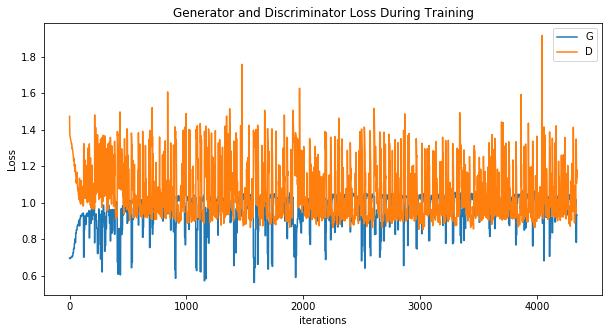

In [7]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

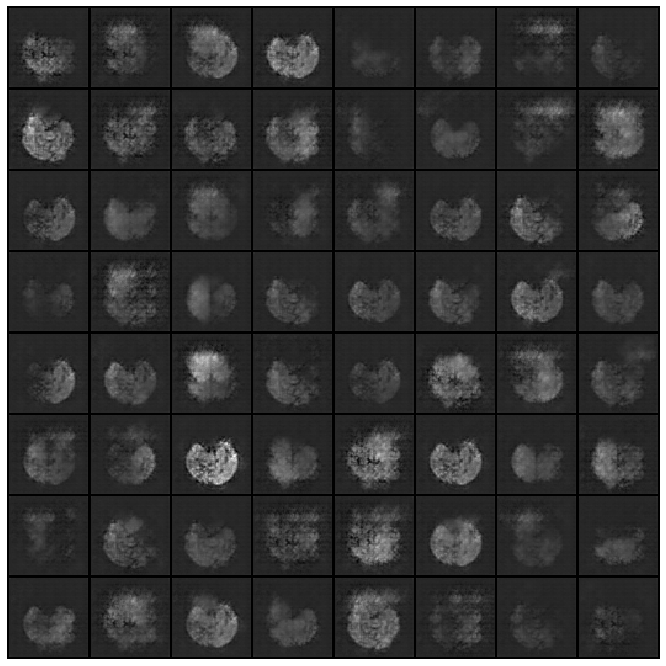

In [9]:
#%%capture
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_grids]
ani = animation.ArtistAnimation(fig, ims, interval= 500, repeat_delay=50, blit=True)

HTML(ani.to_jshtml())

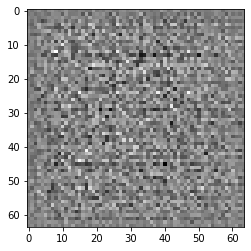

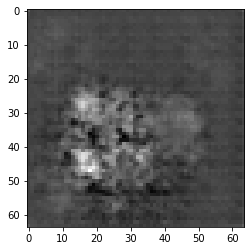

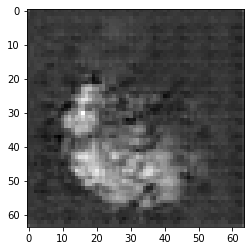

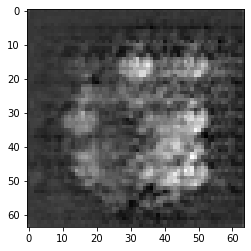

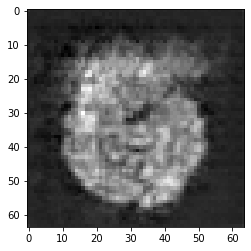

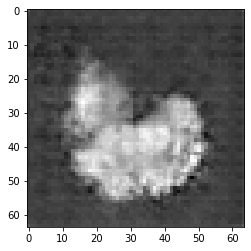

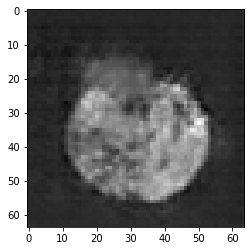

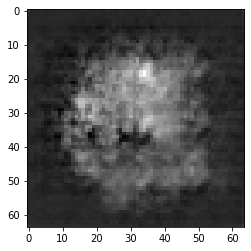

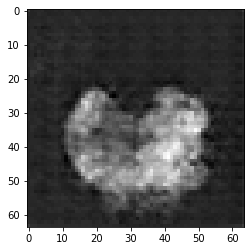

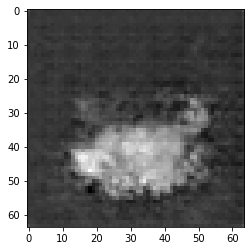

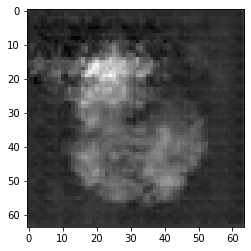

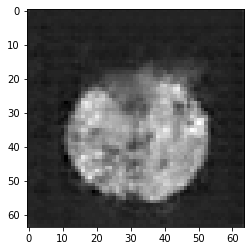

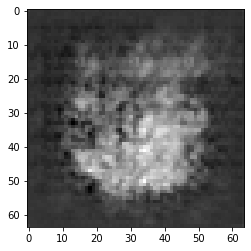

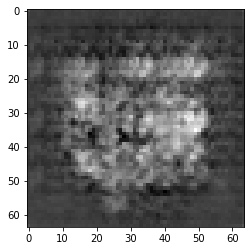

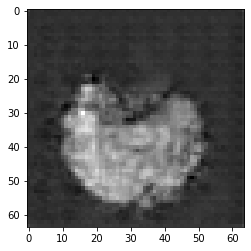

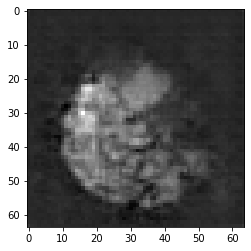

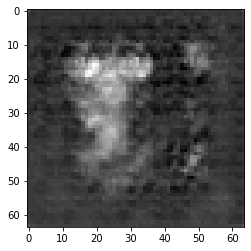

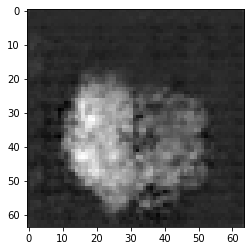

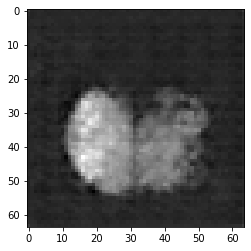

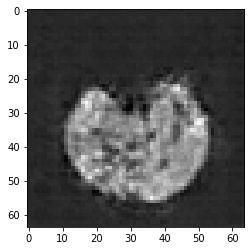

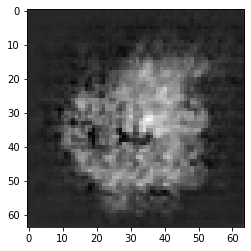

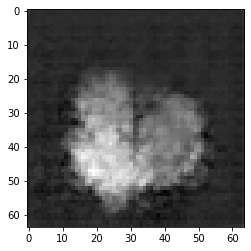

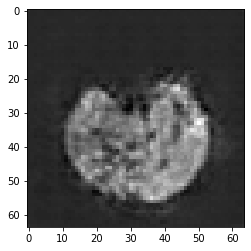

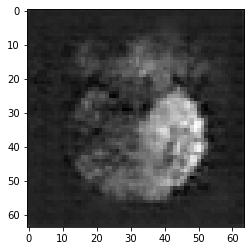

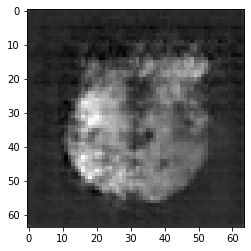

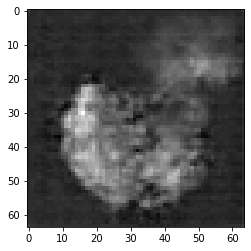

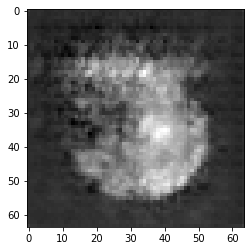

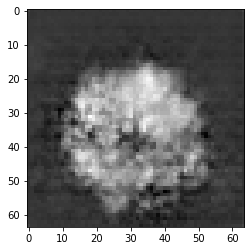

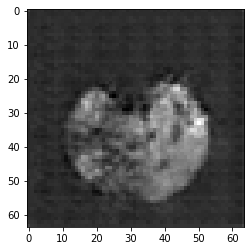

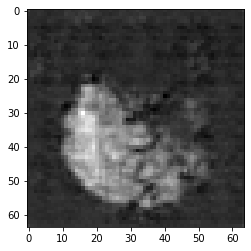

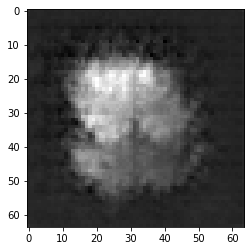

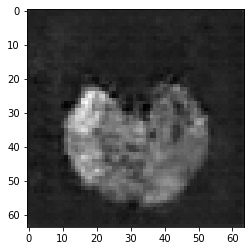

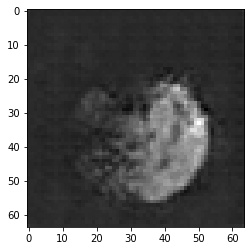

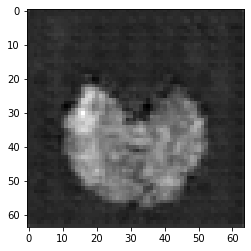

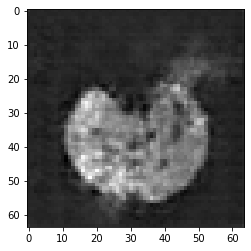

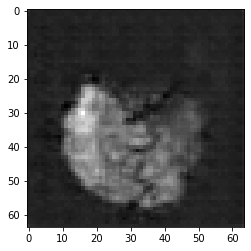

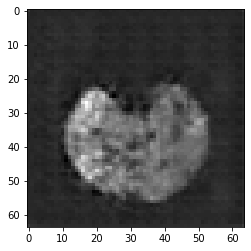

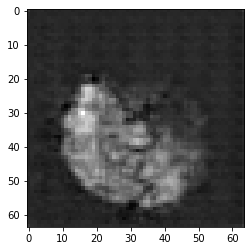

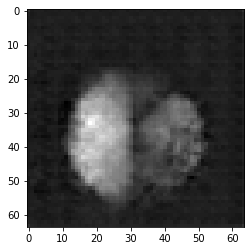

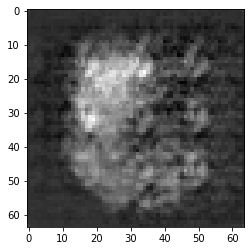

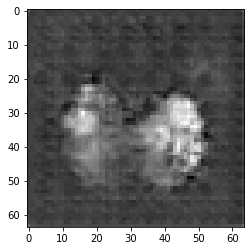

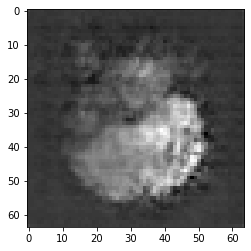

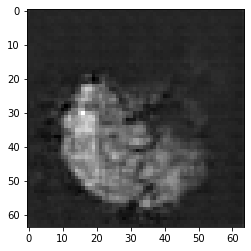

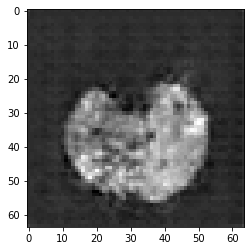

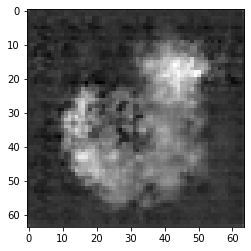

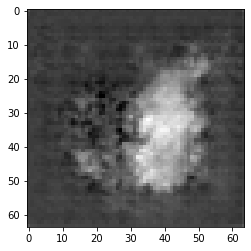

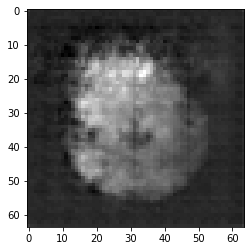

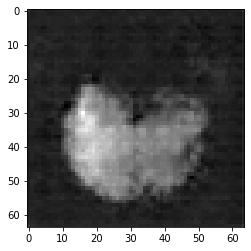

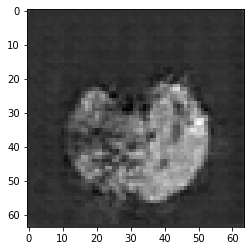

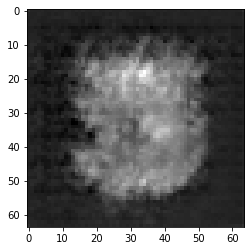

In [10]:
for i in tqdm(range(50)):
    plt.imshow(imgs[-i].reshape(64, 64), cmap = 'gray')
    plt.show()

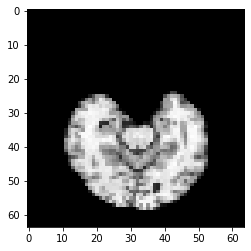

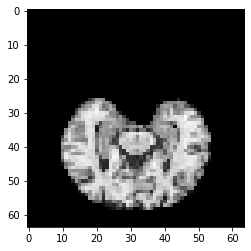

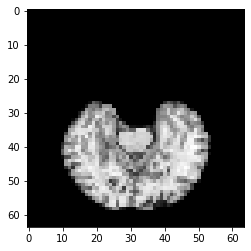

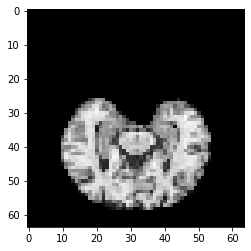

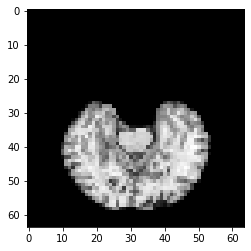

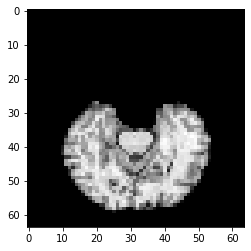

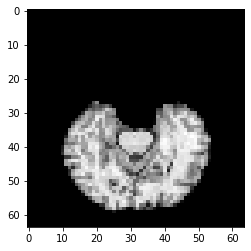

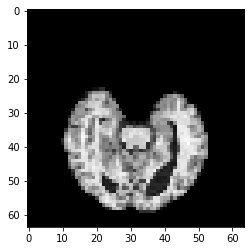

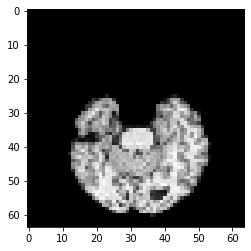

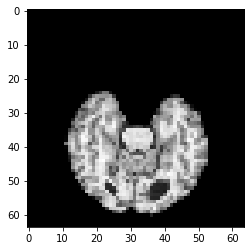

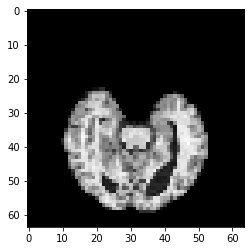

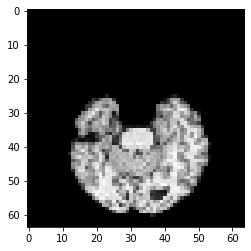

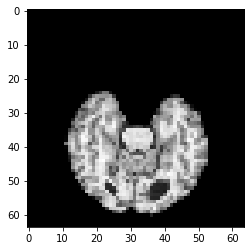

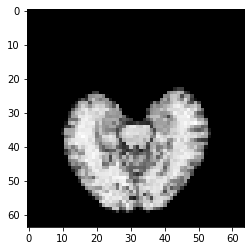

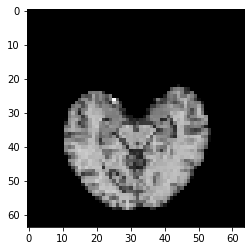

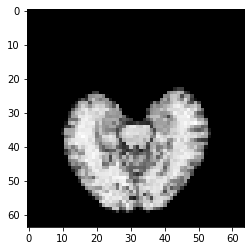

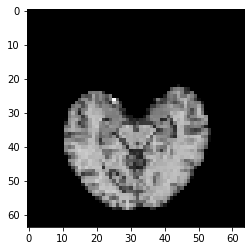

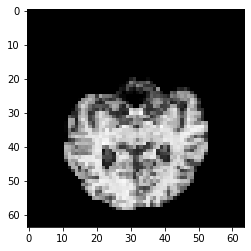

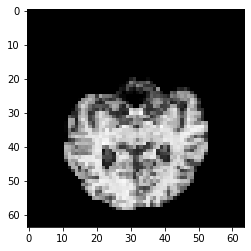

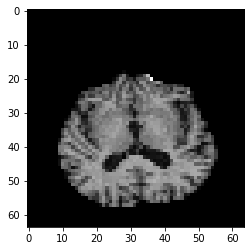

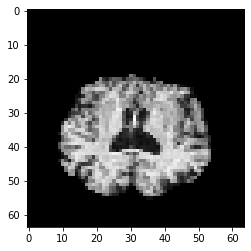

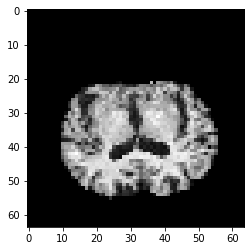

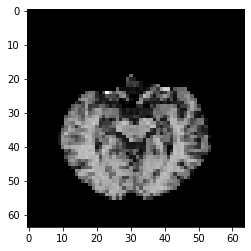

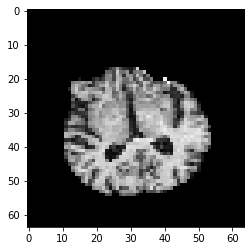

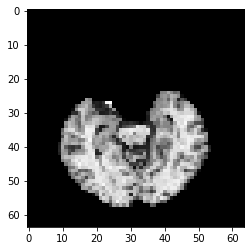

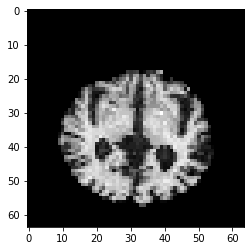

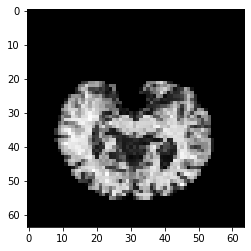

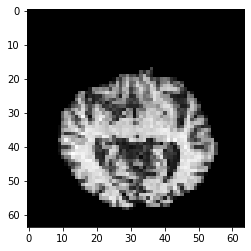

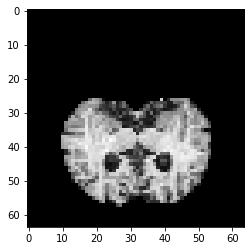

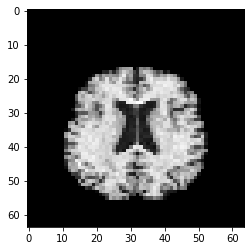

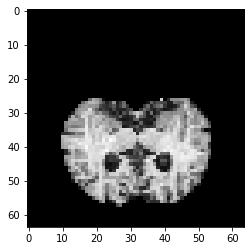

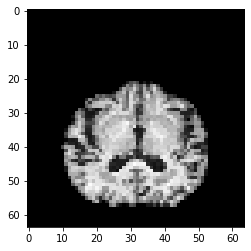

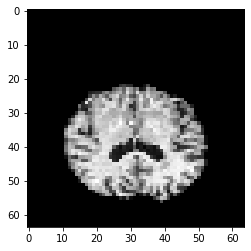

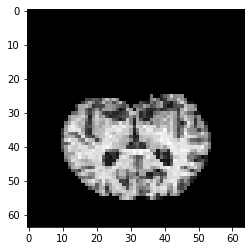

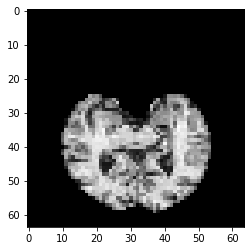

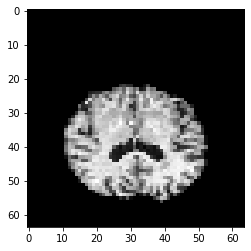

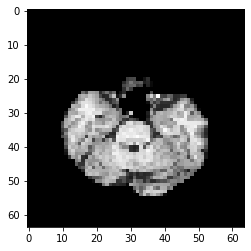

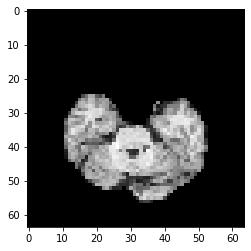

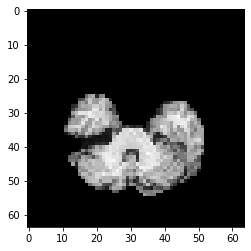

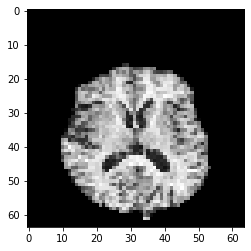

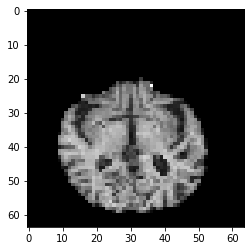

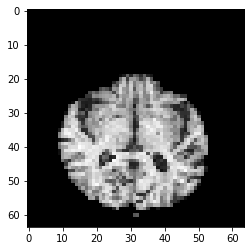

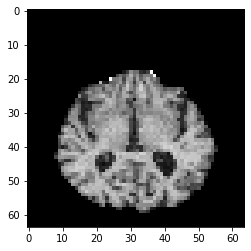

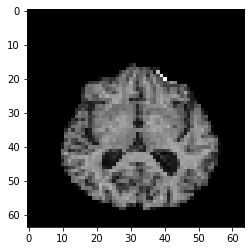

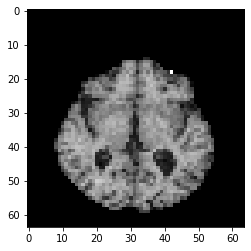

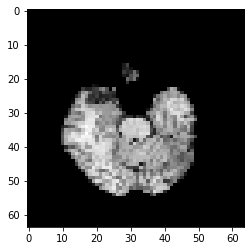

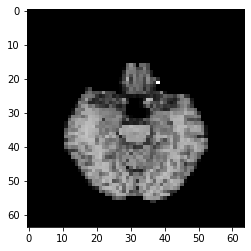

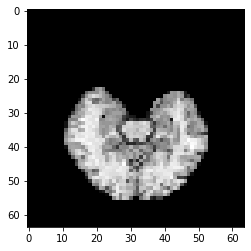

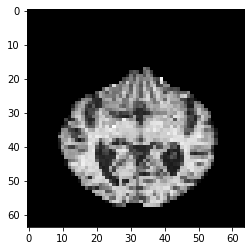

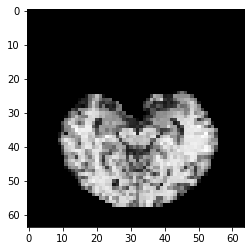

In [11]:
for i in tqdm(range(50)):
    plt.imshow(NCgan1[-i].reshape(64, 64), cmap = 'gray')
    plt.show()

In [38]:
print(imgs[-1].max(), NCgan3[124].max())

tensor(1.2043) tensor(1.3715, dtype=torch.float64)


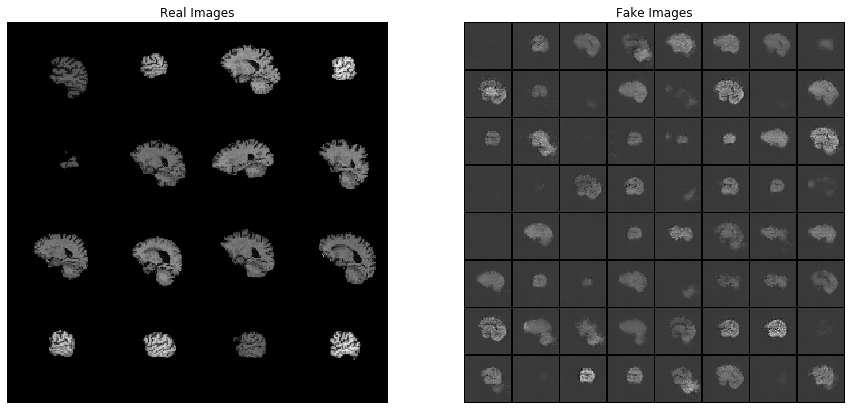

In [31]:
real_batch = next(iter(dataloader3))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:16], nrow = 4, padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
real_batch = next(iter(dataloader1))

# Plot the real images
plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device), nrow = 4, padding=5, normalize=True).cpu(),(1,2,0)))
